# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

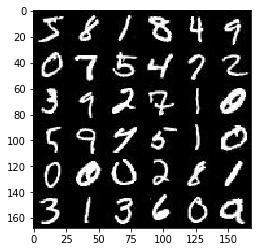

In [2]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

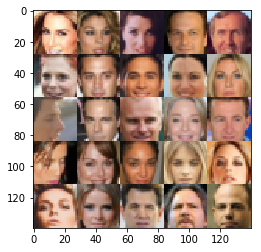

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, \
                        image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate',shape=())
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


# Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse = reuse):
        alpha = 0.1
        x1 = tf.layers.conv2d(images,64,5,strides=2,padding='same')
        relu1 = tf.maximum(alpha*x1,x1)
        
        x2 = tf.layers.conv2d(relu1,128,5,strides=2,padding='same')
        bn2 = tf.layers.batch_normalization(x2,training=True)
        relu2 = tf.maximum(alpha*bn2,bn2)
        
        x3 = tf.layers.conv2d(relu2,256,5,strides=5,padding='same')
        bn3 = tf.layers.batch_normalization(x3,training=True)
        relu3 = tf.maximum(alpha*bn3,bn3)
        
        flatten_out = tf.reshape(relu3,(-1,4*4*256))
        logits = tf.layers.dense(flatten_out,1)
        out = tf.nn.sigmoid(logits)
        
    return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse = not is_train):
        alpha = 0.1
        x1 = tf.layers.dense(z,7*7*512)
        x1 = tf.reshape(x1,(-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1,training = is_train)
        x1 = tf.maximum(alpha*x1,x1)
        
        x2 = tf.layers.conv2d_transpose(x1,256,5,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(alpha*x2,x2)
        
        x3 = tf.layers.conv2d_transpose(x2,128,5,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x3,training = is_train)
        x3 = tf.maximum(alpha*x3,x3)
        
        logits = tf.layers.conv2d_transpose(x3,out_channel_dim,3,strides=1,padding='same')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z,out_channel_dim)
    d_model_real,d_logits_real = discriminator(input_real)
    d_model_fake,d_logits_fake = discriminator(g_model,reuse = True)     
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss,g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1 = beta1).minimize(d_loss,var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1 = beta1).minimize(g_loss,var_list = g_vars)
    return d_train_opt,g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    steps = 0


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model

                steps += 1
                
                batch_images = batch_images*2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
            
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval(feed_dict={input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess,batch_size, input_z, data_shape[3], data_image_mode)

 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0052... Generator Loss: 6.1740
Epoch 1/2... Discriminator Loss: 0.0018... Generator Loss: 7.4835
Epoch 1/2... Discriminator Loss: 0.0017... Generator Loss: 7.9468
Epoch 1/2... Discriminator Loss: 0.0007... Generator Loss: 8.3299
Epoch 1/2... Discriminator Loss: 0.0006... Generator Loss: 8.6762
Epoch 1/2... Discriminator Loss: 0.0009... Generator Loss: 8.8868
Epoch 1/2... Discriminator Loss: 0.0006... Generator Loss: 8.9691
Epoch 1/2... Discriminator Loss: 0.0003... Generator Loss: 10.5394
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 10.0518
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 9.5466


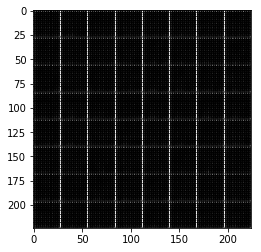

Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 10.8038
Epoch 1/2... Discriminator Loss: 0.0020... Generator Loss: 14.5583
Epoch 1/2... Discriminator Loss: 0.0003... Generator Loss: 14.4995
Epoch 1/2... Discriminator Loss: 0.0020... Generator Loss: 6.3875
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 9.4598
Epoch 1/2... Discriminator Loss: 0.0045... Generator Loss: 5.5075
Epoch 1/2... Discriminator Loss: 0.0005... Generator Loss: 8.1044
Epoch 1/2... Discriminator Loss: 0.0003... Generator Loss: 8.3953
Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 18.4629
Epoch 1/2... Discriminator Loss: 0.0039... Generator Loss: 13.9462


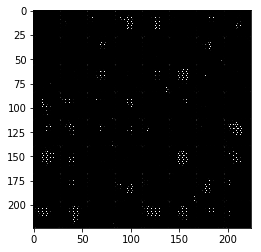

Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 10.7556
Epoch 1/2... Discriminator Loss: 0.0013... Generator Loss: 11.0115
Epoch 1/2... Discriminator Loss: 0.0009... Generator Loss: 10.9654
Epoch 1/2... Discriminator Loss: 0.0008... Generator Loss: 10.5007
Epoch 1/2... Discriminator Loss: 0.0024... Generator Loss: 11.0663
Epoch 1/2... Discriminator Loss: 0.0012... Generator Loss: 10.8665
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 10.5990
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 10.2614
Epoch 1/2... Discriminator Loss: 0.0013... Generator Loss: 8.6607
Epoch 1/2... Discriminator Loss: 0.0047... Generator Loss: 6.3306


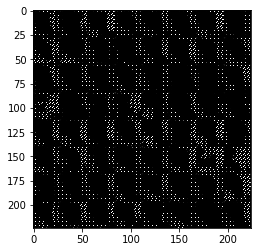

Epoch 1/2... Discriminator Loss: 0.0709... Generator Loss: 19.0438
Epoch 1/2... Discriminator Loss: 0.0062... Generator Loss: 17.8695
Epoch 1/2... Discriminator Loss: 0.0549... Generator Loss: 6.5338
Epoch 1/2... Discriminator Loss: 0.0104... Generator Loss: 4.9392
Epoch 1/2... Discriminator Loss: 0.0062... Generator Loss: 6.2004
Epoch 1/2... Discriminator Loss: 0.0024... Generator Loss: 7.3023
Epoch 1/2... Discriminator Loss: 0.0030... Generator Loss: 7.4859
Epoch 1/2... Discriminator Loss: 0.0016... Generator Loss: 8.1551
Epoch 1/2... Discriminator Loss: 0.0008... Generator Loss: 8.3473
Epoch 1/2... Discriminator Loss: 0.0020... Generator Loss: 8.3000


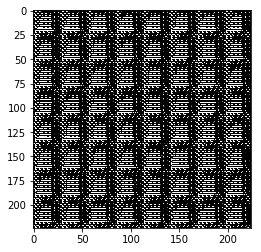

Epoch 1/2... Discriminator Loss: 0.0005... Generator Loss: 8.4880
Epoch 1/2... Discriminator Loss: 0.0017... Generator Loss: 8.4978
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 8.8777
Epoch 1/2... Discriminator Loss: 0.0008... Generator Loss: 9.4142
Epoch 1/2... Discriminator Loss: 0.0006... Generator Loss: 9.8084
Epoch 1/2... Discriminator Loss: 0.0003... Generator Loss: 9.6799
Epoch 1/2... Discriminator Loss: 0.0009... Generator Loss: 9.9170
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 9.9507
Epoch 1/2... Discriminator Loss: 0.0003... Generator Loss: 10.0515
Epoch 1/2... Discriminator Loss: 0.0004... Generator Loss: 10.1368


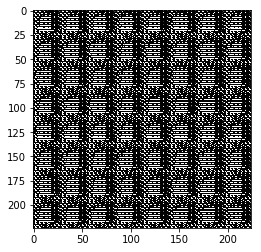

Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 10.3590
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 10.2451
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 10.4985
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 10.5905
Epoch 1/2... Discriminator Loss: 0.0004... Generator Loss: 10.6696
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 10.5224
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 10.5984
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 10.7470
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 10.5917
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 10.8547


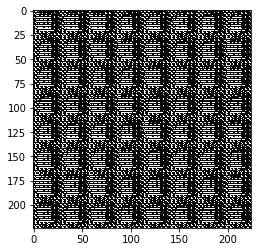

Epoch 1/2... Discriminator Loss: 0.0012... Generator Loss: 10.5480
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 10.4620
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 10.5363
Epoch 1/2... Discriminator Loss: 0.0003... Generator Loss: 10.3981
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 10.3515
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 10.4802
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 10.5371
Epoch 1/2... Discriminator Loss: 0.0003... Generator Loss: 10.6776
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 10.6817
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 10.7120


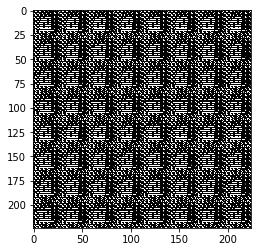

Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 10.7515
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 10.9408
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 10.8875
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 10.9425
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 10.9598
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 11.2828
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 11.1194
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 11.1977
Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 11.1653
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 10.5659


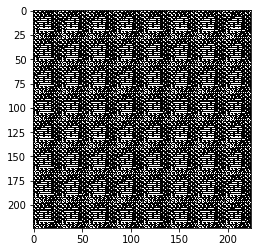

Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 10.6587
Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 10.7907
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 10.6932
Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 10.7681
Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 10.9645
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 11.0173
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 10.9852
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 10.5195
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 10.2939
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 10.2507


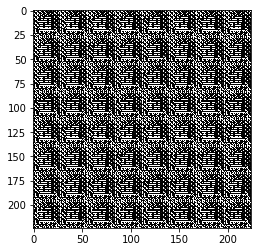

Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 10.5077
Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 10.7016
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 10.6998
Epoch 2/2... Discriminator Loss: 0.0002... Generator Loss: 10.7633
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 10.9195
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 10.8487
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 11.0348
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 11.2279
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 11.2150
Epoch 2/2... Discriminator Loss: 0.0002... Generator Loss: 11.3146


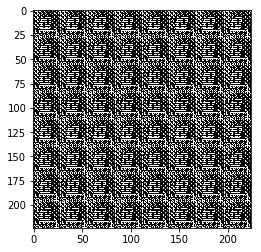

Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 11.3514
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 11.3974
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 11.4193
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 11.4458
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 11.4330
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 11.6415
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 11.5482
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 11.5927
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 11.4626
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 11.6382


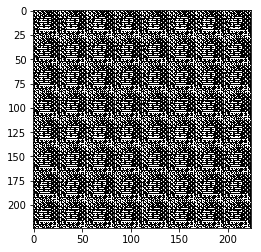

Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 11.5500
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 11.6181
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 11.5534
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 11.3793
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 11.6214
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 11.5130
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 11.5219
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 11.8279
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 11.9286
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 11.6757


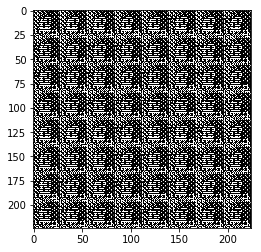

Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 11.9874
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 11.8135
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 11.8998
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 11.9914
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 11.7321
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.0291
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.1222
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 11.9852
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.2738
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.2240


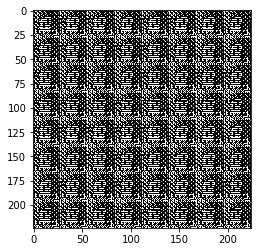

Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.0370
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.1471
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.1562
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.2155
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 12.3121
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.2387
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.1547
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.3191
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.0473
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 12.1143


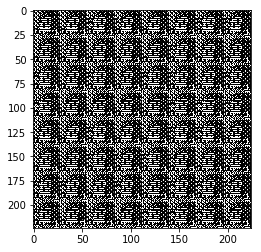

Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.1185
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.2842
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.1233
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.2175
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.2821
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.1361
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 12.3557
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.4802
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.1213
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.0806


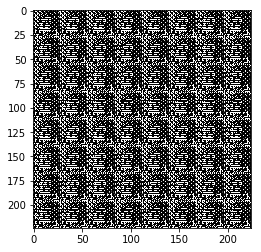

Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 11.7893
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 11.8291
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 11.9710
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 12.4909
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.1895
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.0097
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 11.8885
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.1243
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.0613
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.0166


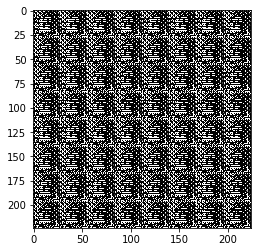

Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.0775
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.2055
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.2814
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.2979
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 12.2799
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.2763
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.4692
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.4086
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.4013
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.3874


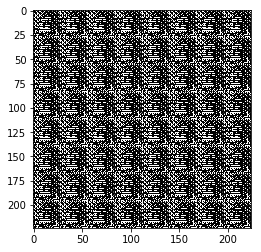

Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.3381
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.5176
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.5714
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.5801
Epoch 2/2... Discriminator Loss: 0.0002... Generator Loss: 12.5140
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.6296
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.7765
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.5327
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.7099
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.7414


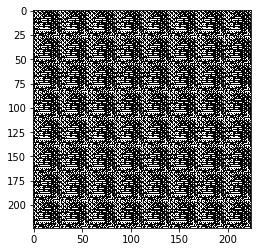

Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.8285
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.6125
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.6605
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.5956
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.6952
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.6409
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 12.8123


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2195... Generator Loss: 1.7957
Epoch 1/1... Discriminator Loss: 0.0026... Generator Loss: 7.4244
Epoch 1/1... Discriminator Loss: 0.4382... Generator Loss: 3.4294
Epoch 1/1... Discriminator Loss: 0.3918... Generator Loss: 4.8340
Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 0.7284... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 0.2180... Generator Loss: 3.3996
Epoch 1/1... Discriminator Loss: 3.3599... Generator Loss: 0.0501
Epoch 1/1... Discriminator Loss: 0.8583... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 0.6939... Generator Loss: 5.3804


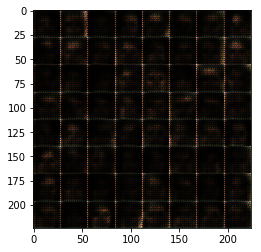

Epoch 1/1... Discriminator Loss: 2.0763... Generator Loss: 0.1911
Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 0.9782
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.4358
Epoch 1/1... Discriminator Loss: 1.6069... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 1.3441
Epoch 1/1... Discriminator Loss: 0.7062... Generator Loss: 1.4583
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.5130
Epoch 1/1... Discriminator Loss: 1.5664... Generator Loss: 0.3895
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.5607


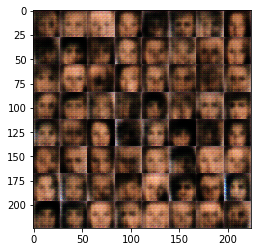

Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 0.9704
Epoch 1/1... Discriminator Loss: 1.7255... Generator Loss: 0.3050
Epoch 1/1... Discriminator Loss: 1.6329... Generator Loss: 0.3393
Epoch 1/1... Discriminator Loss: 0.8643... Generator Loss: 1.2763
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.5747
Epoch 1/1... Discriminator Loss: 1.8904... Generator Loss: 0.2793
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.5195
Epoch 1/1... Discriminator Loss: 1.5540... Generator Loss: 1.8701


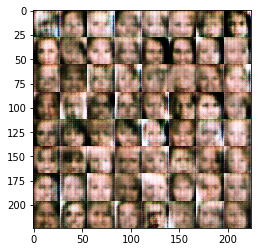

Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.5677... Generator Loss: 0.4028
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.5254
Epoch 1/1... Discriminator Loss: 1.6098... Generator Loss: 0.3134
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.5929
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.6723


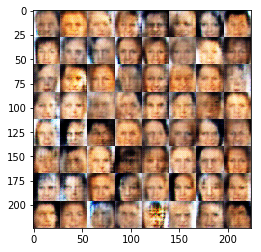

Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.9618
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.5081... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 1.6384... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.4514
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.6126


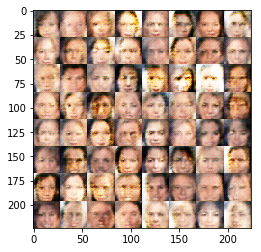

Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.5688
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.6105... Generator Loss: 0.3984
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.5946
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.4060
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.5936


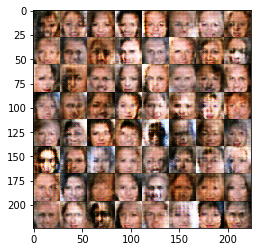

Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.5097
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.5692
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.5084
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.4646
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.5586


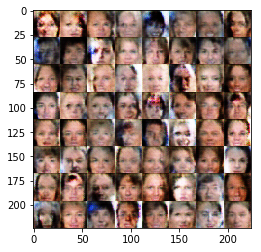

Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.5399
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.5688
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.5243
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.5194


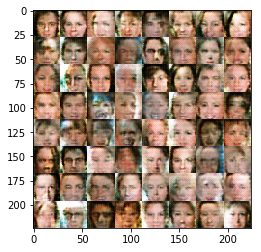

Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.6317... Generator Loss: 0.3768
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.4611
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.4924
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.5544
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.6466


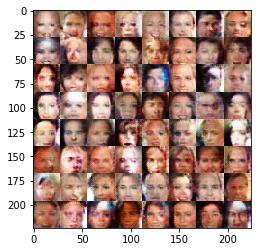

Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.5247
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.5417
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.4964
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.6083


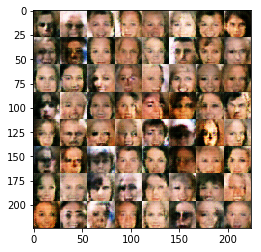

Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.5217
Epoch 1/1... Discriminator Loss: 1.5483... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.4105
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.9443
Epoch 1/1... Discriminator Loss: 1.5801... Generator Loss: 0.4808
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.6702


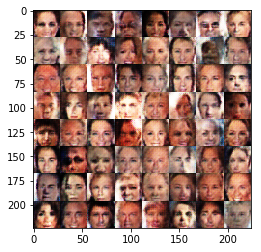

Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 1.1283
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.6551


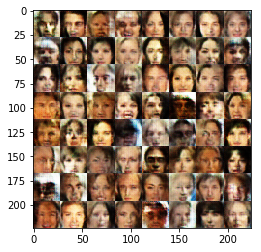

Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 1.1420
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.4959
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.4256


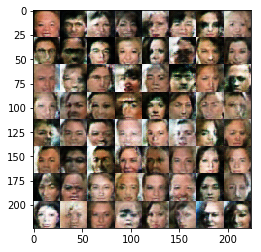

Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.4526
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.4038
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.5285
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.5156
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 0.6821


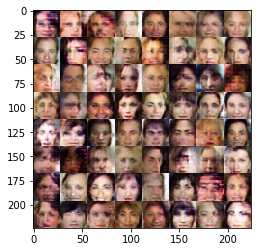

Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.5698
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.4231
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.5741
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.5072
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.5978


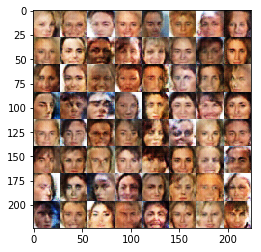

Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.5323
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.5787
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.5865


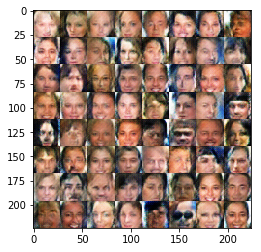

Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.5364
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.5176
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.4216
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.5606
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.6585


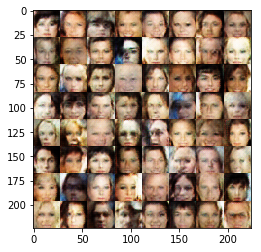

Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.5245
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.5820... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.6808


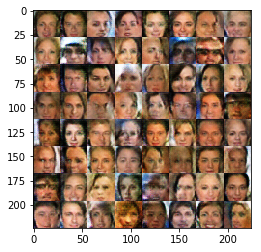

Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.5001... Generator Loss: 0.4893
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.5796
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 1.5595... Generator Loss: 0.5307
Epoch 1/1... Discriminator Loss: 1.5790... Generator Loss: 0.4927
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.4461
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.5522


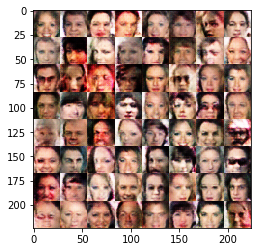

Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.4716
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.5051
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.4972
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.4903
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.4777


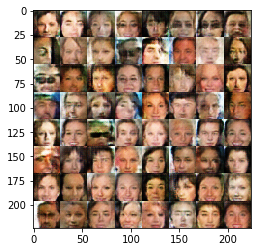

Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.5193
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.5577
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.5680
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.5688
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.5421


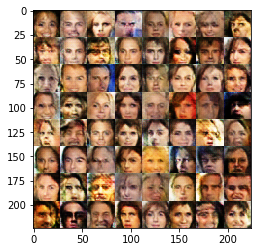

Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.4815
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.4570
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.5708
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.6738


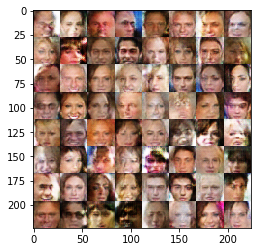

Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.5994


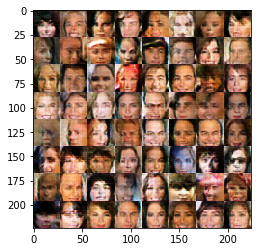

Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.5395
Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.5159
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.5860
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.6115


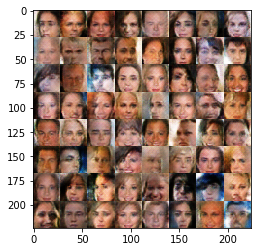

Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.5499
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.5576... Generator Loss: 0.4381
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.5594
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.5072


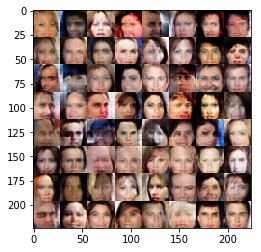

Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.5784
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.5388
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.4781
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.5338
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.6187


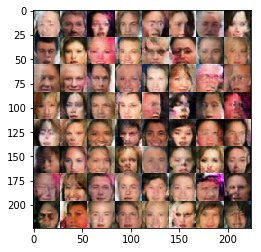

Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.5836... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.6395


KeyboardInterrupt: 

In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.